In [1]:
import pandas as pd
import numpy as np
import re
import json
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# from sklearn.tree._tree import DecisionTreeClassifier

import pickle

import math

ModuleNotFoundError: No module named 'sklearn'

In [99]:
df_vessel_density = pd.read_csv("vessel_density.csv", index_col=None)

In [100]:
def get_fileinfo(series):
    """Returns key values and parameters from the filenames

    Args:
        series (pandas.Series): row
    """
    pattern = r"^[a-zA-Z0-9_ ]+[_](\w+)[-](\w+)_sub-(\d+)[.]\w+[_](\w+).csv$"
    result = re.search(pattern, series["filename"])
    series["side"] = result.groups()[0]
    series["layer"] = result.groups()[1]
    series["record"] = int(result.groups()[2])
    series["region"] = result.groups()[3]
    list_image_label = ["R", "D"]
    if(series["layer"] == "Superficial"):
        list_image_label[1] = "S"
    if(series["side"] == "OS"):
        list_image_label[0] = "L"
    series["label"] = "".join(list_image_label)
    return(series)

In [101]:
df_vessel_density = df_vessel_density.apply(get_fileinfo, axis=1)
df_vessel_density = df_vessel_density.drop(columns="filename")

In [102]:
df_vessel_density = df_vessel_density[["record", "region", "label", "vessel_density"]]
df_vessel_density.head(10)

,record,region,label,vessel_density
0,32,IT,RS,61.854353
1,32,IN,RS,62.046104
2,32,IS,RS,70.803677
3,32,IS,LS,64.074333
4,32,II,RD,91.834667
5,32,II,LD,75.107614
6,32,innerCircle,LS,41.975969
7,32,II,LS,65.978194
8,32,innerCircle,LD,63.180939
9,32,IS,LD,79.368926


In [103]:
df_train = pd.DataFrame(pd.pivot_table(data=df_vessel_density, values="vessel_density", columns=["region"], index=["record", "label"]).to_records())
df_train["side"] = df_train["label"].apply(lambda label: label[0])

In [104]:
display(df_train[df_train["record"] == 1])
display(df_vessel_density[(df_vessel_density["record"] == 1) & (df_vessel_density["label"] == "LD")])

,record,label,II,IN,IS,IT,innerCircle,side
0,1,LD,76.812409,76.036873,80.069378,76.003358,34.717816,L
1,1,LS,63.338113,61.187351,62.933060,58.250268,10.793844,L
2,1,RD,72.448235,70.886130,73.243406,72.858762,34.637471,R
3,1,RS,59.915487,55.802535,63.632754,62.691014,10.020115,R


,record,region,label,vessel_density
783,1,IS,LD,80.069378
788,1,IT,LD,76.003358
791,1,II,LD,76.812409
794,1,IN,LD,76.036873
799,1,innerCircle,LD,34.717816


In [105]:
df_train = df_train.groupby(["record", "side"]).mean().reset_index()
df_train.head()

,record,side,II,IN,IS,IT,innerCircle
0,1,L,70.075261,68.612112,71.501219,67.126813,22.755830
1,1,R,66.181861,63.344332,68.438080,67.774888,22.328793
2,2,L,80.886921,75.638779,81.200726,76.363870,37.660175
3,2,R,79.237816,74.719413,78.558164,74.314481,39.195148
4,3,L,51.298988,47.806874,52.218992,44.327837,18.189336


In [106]:
# Add dependent variable
path_data_dictionary = "/home/chinmay/Documents/UTHealth/Others/bmi_6002/dataset/pat-info-dataset-paper2022.csv"
df_dict = pd.read_csv(path_data_dictionary, index_col=None)
# df_dict.groupby("stroke_type", dropna=False).count().reset_index()[["stroke_type", "record_id"]]
df_train = df_train.merge(left_on="record", right_on="record_id", right=df_dict)[
    list(df_train.columns) + ["stroke"]]

In [107]:
df_train.groupby("stroke").count().reset_index()[["stroke", "record"]]

,stroke,record
0,0,76
1,1,18


In [108]:
def annotate_boxplot(bpdict, annotate_params=None,
                     x_offset=0.05, x_loc=0,
                     text_offset_x=35,
                     text_offset_y=-20, ax=None):
    """Annotates a matplotlib boxplot with labels marking various centile levels.

    Parameters:
    - bpdict: The dict returned from the matplotlib `boxplot` function. If you're using pandas you can
    get this dict by setting `return_type='dict'` when calling `df.boxplot()`.
    - annotate_params: Extra parameters for the plt.annotate function. The default setting uses standard arrows
    and offsets the text based on other parameters passed to the function
    - x_offset: The offset from the centre of the boxplot to place the heads of the arrows, in x axis
    units (normally just 0-n for n boxplots). Values between around -0.15 and 0.15 seem to work well
    - x_loc: The x axis location of the boxplot to annotate. Usually just the number of the boxplot, counting
    from the left and starting at zero.
    text_offset_x: The x offset from the arrow head location to place the associated text, in 'figure points' units
    text_offset_y: The y offset from the arrow head location to place the associated text, in 'figure points' units
    """
    print(bpdict["whiskers"], "\n\n")
    if annotate_params is None:
        annotate_params = dict(xytext=(text_offset_x, text_offset_y), textcoords='offset points', arrowprops={'arrowstyle':'->'})

    ax.annotate('Median', (x_loc + 1 + x_offset, bpdict['medians'][x_loc].get_ydata()[0]), **annotate_params)
    ax.annotate('25%', (x_loc + 1 + x_offset, bpdict['boxes'][x_loc].get_ydata()[0]), **annotate_params)
    ax.annotate('75%', (x_loc + 1 + x_offset, bpdict['boxes'][x_loc].get_ydata()[2]), **annotate_params)
    ax.annotate('5%', (x_loc + 1 + x_offset, bpdict['caps'][x_loc*2].get_ydata()[0]), **annotate_params)
    ax.annotate('95%', (x_loc + 1 + x_offset, bpdict['caps'][(x_loc*2)+1].get_ydata()[0]), **annotate_params)

[<matplotlib.lines.Line2D object at 0x7f03332eee80>, <matplotlib.lines.Line2D object at 0x7f03332dd220>, <matplotlib.lines.Line2D object at 0x7f03332c76a0>, <matplotlib.lines.Line2D object at 0x7f03332c7a00>] 


[<matplotlib.lines.Line2D object at 0x7f03332e7790>, <matplotlib.lines.Line2D object at 0x7f03332e7af0>, <matplotlib.lines.Line2D object at 0x7f0333324f70>, <matplotlib.lines.Line2D object at 0x7f0333319310>] 


[<matplotlib.lines.Line2D object at 0x7f0333305f70>, <matplotlib.lines.Line2D object at 0x7f033337b310>, <matplotlib.lines.Line2D object at 0x7f0333355790>, <matplotlib.lines.Line2D object at 0x7f0333355af0>] 


[<matplotlib.lines.Line2D object at 0x7f0333350760>, <matplotlib.lines.Line2D object at 0x7f0333350ac0>, <matplotlib.lines.Line2D object at 0x7f0333346f40>, <matplotlib.lines.Line2D object at 0x7f033343f2e0>] 




Text(0.5, 0.98, 'Vessel density across stroke and control groups in non-fovea regions')

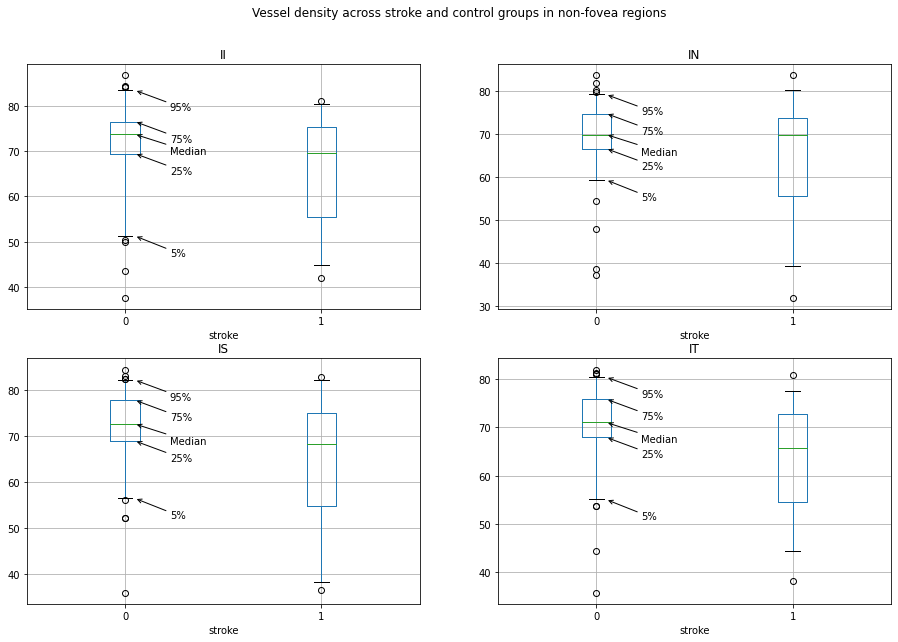

In [109]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
annotate_boxplot(df_train.boxplot(by="stroke", column=["II"], ax=ax1, return_type="dict", whis=[5, 95])["II"], ax=ax1)
annotate_boxplot(df_train.boxplot(by="stroke", column=["IN"], ax=ax2, return_type="dict", whis=[5, 95])["IN"], ax=ax2)
annotate_boxplot(df_train.boxplot(by="stroke", column=["IS"], ax=ax3, return_type="dict", whis=[5, 95])["IS"], ax=ax3)
x = annotate_boxplot(df_train.boxplot(by="stroke", column=["IT"], ax=ax4, return_type="dict", whis=[5, 95])["IT"], ax=ax4)
fig.suptitle("Vessel density across stroke and control groups in non-fovea regions")

In [110]:
def get_metrics(y_pred, y_test):
    cm = metrics.confusion_matrix(y_test, y_pred)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return(cm, precision, recall)

In [111]:
df_train.to_csv("train.csv", index=False)

In [112]:
X = df_train[["II", "IN", "IS", "IT", "innerCircle"]]
y = df_train["stroke"]
cv = LeaveOneOut()
y_true, y_pred= list(), list()

model_loocv = LogisticRegression(random_state=0, warm_start=True)

for train_ix, test_ix in tqdm(cv.split(X)):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

    model_loocv.fit(X_train, y_train)

    yhat = model_loocv.predict(X_test)

    # Store
    y_true.append(y_test)
    y_pred.append(yhat[0])


# Calculate accuracy
acc = metrics.accuracy_score(y_true, y_pred)
print(acc)
print(metrics.confusion_matrix(y_true, y_pred))

0it [00:00, ?it/s]

0.8404255319148937
[[72  4]
 [11  7]]


In [113]:
X_test
model_loocv.predict(pd.DataFrame([{
    "II": 88,
    "IN": 87,
    "IS": 83,
    "IT": 79,
    "innerCircle": 45
}]))

array([1])

In [114]:
pickle.dump(model_loocv, open("model.pkl", "wb"))

In [115]:
types = [("float_input", FloatTensorType([None, 4]))]
types
onnx = convert_sklearn(model_loocv, initial_types=types)
with open("model.onnx", "wb") as f:
    f.write(onnx.SerializeToString())


In [116]:
# sess = onnxruntime.InferenceSession(
#     "model.onnx", providers=onnxruntime.get_available_providers())
# input_name = sess.get_inputs()[0].name
# label_name = sess.get_outputs()[0].name
# # pred_onx = sess.run(None, {input_name: [88, 87, 83, 79, 80]})
# # print(pred_onx)
# # dir(sess)
# # sess._inputs_meta
# # dir(sess._inputs_meta)
# sess._inputs_meta.count

In [117]:
def logistic_regression_to_json(lrmodel, file=None):
    if file is not None:
        def serialize(x): return json.dump(x, file)
    else:
        serialize = json.dumps
    data = {}
    data['init_params'] = lrmodel.get_params()
    data['model_params'] = mp = {}
    for p in ('coef_', 'intercept_', 'classes_', 'n_iter_'):
        mp[p] = getattr(lrmodel, p).tolist()
    return serialize(data)


def logistic_regression_from_json(jstring):
    data = json.loads(jstring)
    model = LogisticRegression(**data['init_params'])
    for name, p in data['model_params'].items():
        setattr(model, name, np.array(p))
    return model


In [118]:
# dir(model_loocv)
model_loocv.feature_names_in_, model_loocv.coef_, model_loocv.intercept_

(array(['II', 'IN', 'IS', 'IT', 'innerCircle'], dtype=object),
 array([[ 0.17599289,  0.03895522, -0.23797869, -0.14315607,  0.17464724]]),
 array([4.60635652]))

In [119]:
X.iloc[0], "\n", y.iloc[0]


model_loocv.predict_proba([X.iloc[0]])

/home/chinmay/Documents/UTHealth/Code/analysis-octa-feat-eng/venv_octa_analysis/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[0.95431531, 0.04568469]])

In [120]:
def lr_formula(row):
    coeffs = model_loocv.coef_
    intercept = model_loocv.intercept_
    prediction = intercept
    values = row.tolist()
    for i in range(len(coeffs)):
        prediction += coeffs[0][i] * values[i]
        # print(coeffs[i], values[i])

    # prediction
    return(1/(1 + math.exp(-prediction)))

In [60]:
i = 0
X.iloc[i], model_loocv.predict_proba([X.iloc[i]]), lr_formula(X.iloc[i])

/home/chinmay/Documents/UTHealth/Code/analysis-octa-feat-eng/venv_octa_analysis/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(II             70.075261
 IN             68.612112
 IS             71.501219
 IT             67.126813
 innerCircle    22.755830
 Name: 0, dtype: float64,
 array([[0., 1.]]),
 1.0)

In [132]:
X_new = X.copy()

In [131]:
model_loocv.predict_proba([X_new.iloc[0]]), lr_formula(X_new.iloc[0])

/home/chinmay/Documents/UTHealth/Code/analysis-octa-feat-eng/venv_octa_analysis/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(array([[0., 1.]]), 1.0)

In [137]:
model_loocv.coef_

array([[ 0.17599289,  0.03895522, -0.23797869, -0.14315607,  0.17464724]])